In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from scipy.sparse import hstack
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
url = "https://raw.githubusercontent.com/AREEG94FAHAD/TaskComplexityEval-24/main/problems_data.jsonl"

df = pd.read_json(url, lines=True)

In [3]:
df.head()

,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree


In [4]:
df['text'] = df['description']+' '+ df['input_description']+' '+df['output_description']

In [5]:
df = df[~(df["text"].str.strip() == "")]

In [6]:
# Replace \n with a space (to avoid merging words) and remove $
df['text'] = df['text'].str.replace('$', '', regex=False)
df['text']=df['text'].str.lower()

In [7]:
def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()

    # 3. Remove extra whitespace
    text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text).strip()

    # 4. Tokenization (split into words)
    tokens = nltk.word_tokenize(text)

    # 5. Remove Stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # 6. Lemmatization (reduce words to their base form)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # 7. Rejoin tokens into a clean string (optional, depending on next step)
    cleaned_text = ' '.join(lemmatized_tokens)

    return cleaned_text


In [8]:
df['text2']=df['text'].apply(preprocess_text)

In [9]:
df['text-size'] = df['text2'].apply(len)

In [10]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),
    min_df=3,
    max_df=0.85,
    sublinear_tf=True
)

X_tfidf = tfidf.fit_transform(df['text2'])
#tf-idf feature

In [11]:
y1 = df['problem_class']
y2 = df['problem_score']

In [12]:
def evaluate_models(X, y, test_size=0.15, random_state=45):


    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    models = {
        "Logistic Regression": LogisticRegression(),
        "Linear SVM": LinearSVC(),
        "Random Forest": RandomForestClassifier(
            n_estimators=300,
            class_weight="balanced",
            random_state=random_state,
            n_jobs=-1
        )
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Macro F1": f1_score(y_test, y_pred, average="macro")
        })

    return pd.DataFrame(results).sort_values("Macro F1", ascending=False)


In [13]:
#this was the first feature try
try1 = df[['text-size']].values


scaler = StandardScaler()
try1_scaled = scaler.fit_transform(try1)

X1 = hstack([X_tfidf, try1_scaled])

In [14]:
results = evaluate_models(X_tfidf, y1)
print(results)

                 Model  Accuracy  Macro F1
1           Linear SVM  0.521880  0.465751
2        Random Forest  0.528363  0.399548
0  Logistic Regression  0.515397  0.391149


In [15]:
results= evaluate_models(X1, y1)
print(results)

                 Model  Accuracy  Macro F1
1           Linear SVM  0.538088  0.490490
0  Logistic Regression  0.546191  0.461623
2        Random Forest  0.531605  0.406987


In [16]:
#second feature try
def text_structure(text):
    words = text.split()

    return pd.Series({
        "log_num_words": np.log1p(len(words)),
        #"num_sentences": text.count('.'),
        #"avg_word_length": np.mean([len(w) for w in words]) if words else 0.0,
        #"num_lines": text.count('\n'),
        "log_num_lines":np.log1p(text.count('\n'))
    })


In [17]:
#try2
try2 = df["text"].apply(text_structure)
try2_dash = hstack([X_tfidf , try2])
evaluate_models(try2_dash, y1)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Model,Accuracy,Macro F1
1,Linear SVM,0.531605,0.479796
0,Logistic Regression,0.547812,0.461506
2,Random Forest,0.523501,0.402276


<Axes: xlabel='log_num_words', ylabel='Count'>

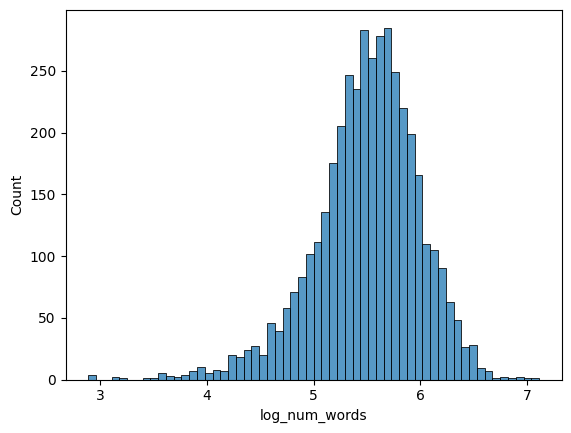

In [18]:
import seaborn as sns
sns.histplot(try2["log_num_words"]) #almost normal distribution

<Axes: xlabel='log_num_lines', ylabel='Count'>

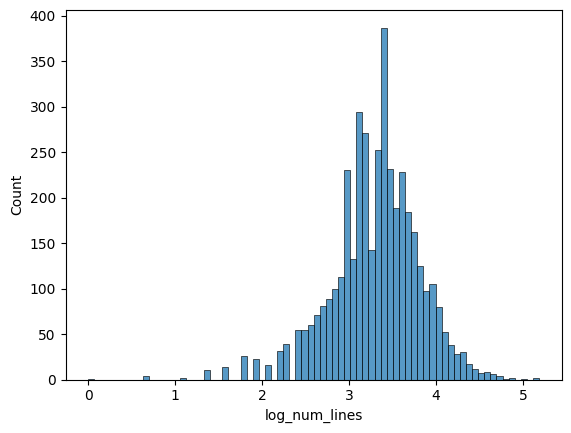

In [19]:
sns.histplot(try2["log_num_lines"]) #normal distribution

In [20]:
df['text'][1]

'a number of eccentrics from central new york have decided\n    that they have had enough of modern society, and want to move\n    from there. together they have bought a rectangular piece of\n    land far away, and will now settle there.\nthe land consists of n \\times\n    m squares, and it is possible to build a maximum of one\n    house on a given square. each square has value a_{x,y} that describes how nice it\n    is, on a scale between 0\n    and 100.\nthe goal of the eccentrics is to get as far away as possible\n    from everyone else, including each other. the happiness an\n    eccentric experiences from building his house on square\n    (x,y) is thus\n    a_{x,y}\\cdot d, where\n    d is the smallest\n    distance to another person.\nout of habit, the eccentrics use manhattan\n    distance to measure this; d is defined as \\min |x - x_2| + |y - y_2| over all\n    other people’s squares (x_2,\n    y_2).\nthe eccentrics now want your help in placing their houses\n    optimally,

In [21]:
#try3
KEYWORD_BUCKETS = {
    "spatial": [
        "grid", "matrix", "cell", "square",
        "row", "column",
        "coordinate", "position", "location",
        "distance", "path", "move", "step",
        "neighbor", "adjacent", "direction",
        "north", "south", "left", "right",
        "x", "y"
    ],

    "optimization": [
        "maximize", "minimize",
        "maximum", "minimum",
        "largest", "smallest",
        "best", "optimal", "optimally",
        "as large as possible",
        "as small as possible"
    ],

    "interaction": [
        "each other", "all other",
        "pair", "between",
        "nearest", "closest", "farthest",
        "distance to", "from every"
    ],

    "math": [
        "sum", "product", "difference",
        "value", "score", "weight",
        "formula", "expression", "equation",
        "mod", "prime", "factor"
    ],

    "constraints": [
        "constraint", "limit",
        "at most", "at least",
        "no more than", "up to",
        "range", "bound"
    ],

    "io": [
        "input", "output", "print",
        "each test case", "multiple test cases",
        "for each", "followed by", "format"
    ]
}


In [22]:
def keyword_bucket_features(text):
    if not isinstance(text, str) or text.strip() == "":
        return pd.Series({
            f"{name}_count": 0
            for name in KEYWORD_BUCKETS
        } | {
            f"{name}_flag": 0
            for name in KEYWORD_BUCKETS
        })

    text = text.lower()

    features = {}

    for bucket_name, words in KEYWORD_BUCKETS.items():
        count = 0
        for w in words:
            if w in text:
                count += text.count(w)

        features[f"{bucket_name}_count"] = count
        features[f"{bucket_name}_flag"] = int(count > 0)

    return pd.Series(features)

In [23]:
X_bucket = df["text"].apply(keyword_bucket_features)

<Axes: xlabel='spatial_count', ylabel='Count'>

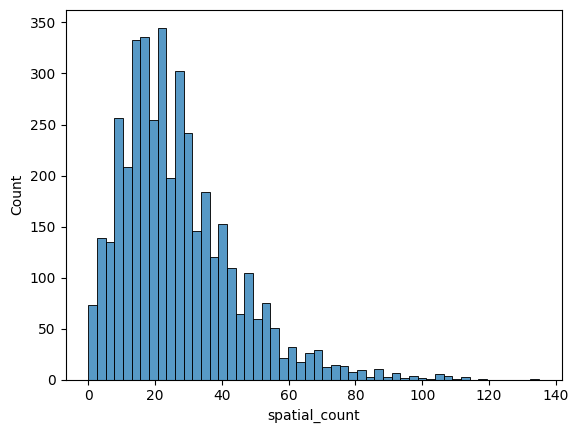

In [24]:
sns.histplot((X_bucket["spatial_count"]))

<Axes: xlabel='problem_class', ylabel='interaction_count'>

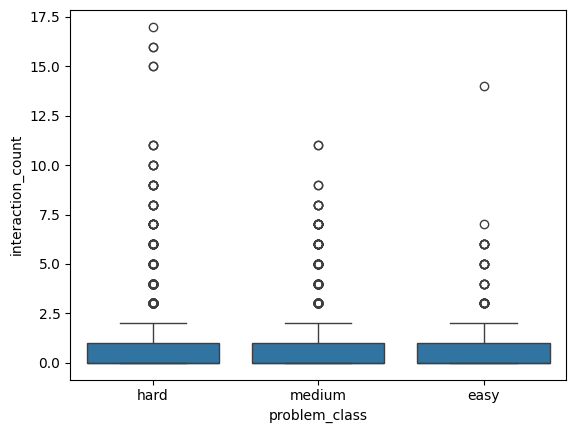

In [25]:
sns.boxplot(
    x=y1,   # Easy / Medium / Hard
    y=X_bucket["interaction_count"]
)

In [26]:
pd.crosstab(
    X_bucket["interaction_flag"],
    y1,
    normalize="columns"
)
#not useful

problem_class,easy,hard,medium
interaction_flag,,,
0,0.681046,0.527563,0.568683
1,0.318954,0.472437,0.431317


In [27]:
from scipy.sparse import csr_matrix
try3 = X_bucket[['spatial_count']]
try3 = try3.fillna(0)
try3_scaled = scaler.fit_transform(try3)
try3_sparse = csr_matrix(try3_scaled)
X3 = hstack([try2_dash , try3_sparse])
evaluate_models(X3, y1)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Model,Accuracy,Macro F1
1,Linear SVM,0.533225,0.479094
0,Logistic Regression,0.549433,0.459308
2,Random Forest,0.531605,0.416441


In [28]:
model = RandomForestClassifier(
            n_estimators=300,
            class_weight="balanced",
            random_state=45,
            n_jobs=-1
        )

In [29]:
def predict_for_rf(X , y ):
  X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.15,
        stratify=y,
        random_state=45
    )
  model.fit(X_train , y_train)
  y_pred = model.predict(X_test)
  print(accuracy_score(y_test, y_pred))
  print(f1_score(y_test, y_pred, average="macro"))

In [30]:
try3_sparse = csr_matrix(try3)
X3_dash = hstack([try3_sparse , try2_dash])
predict_for_rf(X3_dash , y1)

0.546191247974068
0.44248837582170913


In [31]:
#try4 not useful
try4 = csr_matrix(X_bucket[['constraints_count']])
X4 = hstack([X3_dash , try4])
predict_for_rf(X4 , y1)

0.5348460291734197
0.42234195487505316


In [32]:
#try5
def fet2(text):
    if not isinstance(text, str):
        return 0
    nums = [int(n) for n in re.findall(r"\d+", text)]
    return max(nums) if nums else 0



In [33]:
try5 = df["text"].apply(fet2)

print(type(try5))
print(try5.head())
try5_np = try5.to_numpy(dtype=np.float64)

try5_log = np.log1p(try5_np)


<class 'pandas.core.series.Series'>
0    2004
1     100
2     192
3     100
4      50
Name: text, dtype: object


<Axes: ylabel='Count'>

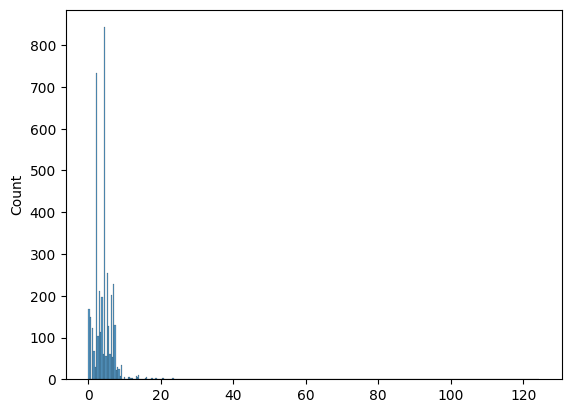

In [34]:
sns.histplot(try5_log)


In [35]:
X5 = hstack([X3_dash , try5_log.reshape(-1, 1)])
predict_for_rf(X5 , y1)

0.5332252836304701
0.41832311560553864


In [36]:
evaluate_models(X5,y1)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Model,Accuracy,Macro F1
0,Logistic Regression,0.570502,0.502431
1,Linear SVM,0.549433,0.443373
2,Random Forest,0.533225,0.418323


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_regression(model, X , y):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, random_state=45)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)

    mae = mean_absolute_error(y_te, preds)
    rmse = np.sqrt(mean_squared_error(y_te, preds))

    return mae, rmse

In [38]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
mae, rmse = evaluate_regression(lin_reg, X5 , y2)

print("Linear Regression")
print("MAE:", mae)
print("RMSE:", rmse)


Linear Regression
MAE: 5.154903954547982
RMSE: 7.114402288381877


In [39]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
mae, rmse = evaluate_regression(ridge, X5 , y2)

print("Ridge Regression")
print("MAE:", mae)
print("RMSE:", rmse)


Ridge Regression
MAE: 1.6473749865180314
RMSE: 1.9857300495977617


In [50]:
df.groupby("problem_class")["problem_score"].agg(["min", "max", "mean", "count"])


,min,max,mean,count
problem_class,,,,
easy,1.1,2.8,1.970458,765
hard,5.5,9.7,7.071149,1941
medium,2.8,5.5,4.125836,1405


In [69]:
CLASS_RANGES = {
    "easy": (1.1 , 2.8),
    "medium": (2.8 , 5.5),
    "hard": (5.5 , 9.7),
}


In [70]:
for cls, (lo, hi) in CLASS_RANGES.items():
    mask = df["problem_class"] == cls
    df.loc[mask, "y_rel"] = (df.loc[mask, "problem_score"] - lo) / (hi - lo)


In [71]:
def denormalize_score(y_rel, cls):
    lo, hi = CLASS_RANGES[cls]
    y_rel = np.clip(y_rel, 0, 1)
    return lo + y_rel * (hi - lo)


In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X5,
    df["y_rel"],
    test_size=0.2,
    random_state=42
)

In [73]:
ridge_rel = Ridge(alpha=1.0)
ridge_rel.fit(X_train , y_train)


Ridge()

In [75]:
pred = ridge_rel.predict(X_test)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.23086129328656566
RMSE: 0.2732034126540998
